# Import the dependencies

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Some theory by ChatGPT:

Here are the top 10 methods commonly used for solving regression problems in Python:

1. Linear Regression: Fits a linear model to the data by minimizing the sum of squared residuals.
2. Decision Tree Regression: Uses a decision tree to make predictions based on feature values.
3. Random Forest Regression: An ensemble method that combines multiple decision trees to make predictions.
4. Gradient Boosting Regression: Builds an ensemble of weak prediction models (usually decision trees) sequentially, where each model corrects the mistakes of the previous one.
5. Support Vector Regression: Uses support vector machines to perform regression by finding the optimal hyperplane that maximally fits the data.
6. Neural Network Regression: Utilizes artificial neural networks to learn and model complex relationships in the data.
7. K-Nearest Neighbors Regression: Makes predictions based on the average of the target values of the k nearest neighbors in the feature space.
8. Ridge Regression: Performs linear regression with a penalty term to prevent overfitting by shrinking the coefficients.
9. Lasso Regression: Performs linear regression with a penalty term that encourages sparsity by forcing some coefficients to be exactly zero.
10. Elastic Net Regression: Combines Ridge and Lasso regression techniques to provide a balance between the two.

These methods offer different approaches and are suitable for various regression problem scenarios. It's important to understand their strengths and limitations and choose the most appropriate method based on your specific dataset, problem requirements, and computational considerations.

# Load data

In [3]:
data = pd.read_csv("src/train.csv")
data = data.drop("Id", axis=1)

data_test = pd.read_csv("src/test.csv")
data_test = data_test.drop("Id", axis=1)
data_test['SalePrice'] = pd.read_csv("src/sample_submission.csv")['SalePrice'].tolist()

data = pd.concat([data, data_test]).reset_index(drop=True)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=["SalePrice"]), data["SalePrice"], test_size=0.5, random_state=42)

In [8]:
data = x_train
data["SalePrice"] = y_train

data_test = x_test
data_test["SalePrice"] = y_test

# Preprocess data

### Define a pipeline for processing data

In [9]:
def preprocess_data(df_data: pd.DataFrame, preproc_obj=None):
    df_data = df_data.copy(deep=True)

    train_preprocessors = preproc_obj is None

    # Encoding Categorical Features
    if train_preprocessors:
        preproc_obj=dict()
        preproc_obj["ss"] = dict()
        preproc_obj["le"] = dict()
        preproc_obj["mms"] = dict()

    for col_name_ in df_data.columns:
        df_data[col_name_] = df_data[col_name_].fillna(0).tolist()

    for key_ in data.keys():
        if data[key_].dtypes == "object":
            if train_preprocessors:
                preproc_obj["le"][key_] = LabelEncoder()
                preproc_obj["le"][key_].fit(df_data[key_].to_list())
            try:
                df_data[key_] = preproc_obj["le"][key_].transform(df_data[key_].to_list())
            except Exception as eeee:
                print(key_)
                raise eeee
        else:
            df_data[key_] = df_data[key_]

    if train_preprocessors:
        df_data.drop(df_data.index[-1], inplace=True)

    # Take log of the Target output
    df_data["SalePrice"] = np.log(df_data["SalePrice"])

    list_keep_data = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition', ]
    list_ss_data = ['MSSubClass', 'LotFrontage', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'YrSold', ]
    list_log_data = ['LotArea', '1stFlrSF', 'GrLivArea', ]

    for col_name_ in list_log_data:
        df_data[col_name_] = np.log(df_data[col_name_])

    for col_name_ in list_ss_data:
        if train_preprocessors:
            preproc_obj["ss"][col_name_] = StandardScaler()
            preproc_obj["ss"][col_name_].fit(np.array(df_data[col_name_]).reshape(-1, 1))
        df_data[col_name_] = preproc_obj["ss"][col_name_].transform(np.array(df_data[col_name_]).reshape(-1, 1))

    for col_name_ in df_data.columns:
        if col_name_ == 'SalePrice':
            continue
        if train_preprocessors:
            preproc_obj["mms"][col_name_] = MinMaxScaler(feature_range=(-1, 1))
            preproc_obj["mms"][col_name_].fit(np.array(df_data[col_name_]).reshape(-1, 1))
        df_data[col_name_] = preproc_obj["mms"][col_name_].transform(np.array(df_data[col_name_]).reshape(-1, 1))

    return df_data, preproc_obj

In [10]:
data_num_train, preprocessing_obj = preprocess_data(data)

In [12]:
len(data_test)

1460

In [41]:
data_test = data_test[[rec != "NoSeWa" for rec in data_test["Utilities"]]].reset_index(drop=True)
data_test = data_test[[rec != "RRNn" for rec in data_test["Condition2"]]].reset_index(drop=True)
data_test = data_test[[rec != "RRAn" for rec in data_test["Condition2"]]].reset_index(drop=True)
data_test = data_test[[rec != "RRAe" for rec in data_test["Condition2"]]].reset_index(drop=True)

data_test = data_test[[rec != "Metal" for rec in data_test["RoofMatl"]]].reset_index(drop=True)
data_test = data_test[[rec != "Membran" for rec in data_test["RoofMatl"]]].reset_index(drop=True)
data_test = data_test[[rec != "ClyTile" for rec in data_test["RoofMatl"]]].reset_index(drop=True)
data_test = data_test[[rec != "ImStucc" for rec in data_test["Exterior1st"]]].reset_index(drop=True)
data_test = data_test[[rec != "CBlock" for rec in data_test["Exterior1st"]]].reset_index(drop=True)
data_test = data_test[[rec != "CBlock" for rec in data_test["Exterior2nd"]]].reset_index(drop=True)
data_test = data_test[[rec != "Othr" for rec in data_test["MiscFeature"]]].reset_index(drop=True)

data_test = data_test[[rec != "Floor" for rec in data_test["Heating"]]].reset_index(drop=True)
data_test = data_test[[rec != "Mix" for rec in data_test["Electrical"]]].reset_index(drop=True)
len(data_test)

1442

In [42]:
data_num_test, _ = preprocess_data(data_test, preprocessing_obj)

In [43]:
rcParams['figure.figsize'] = 10, 12


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()


def draw_few_lines(lines_dict: dict, range_draw=None, x_label="x", y_label="y", title="f(x)"):
    for key_, val_ in lines_dict.items():
        plt.plot(range(len(val_)) if not range_draw else range_draw, val_, label=key_)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# 1. Tune Linear Regression model

0.03495223615034192


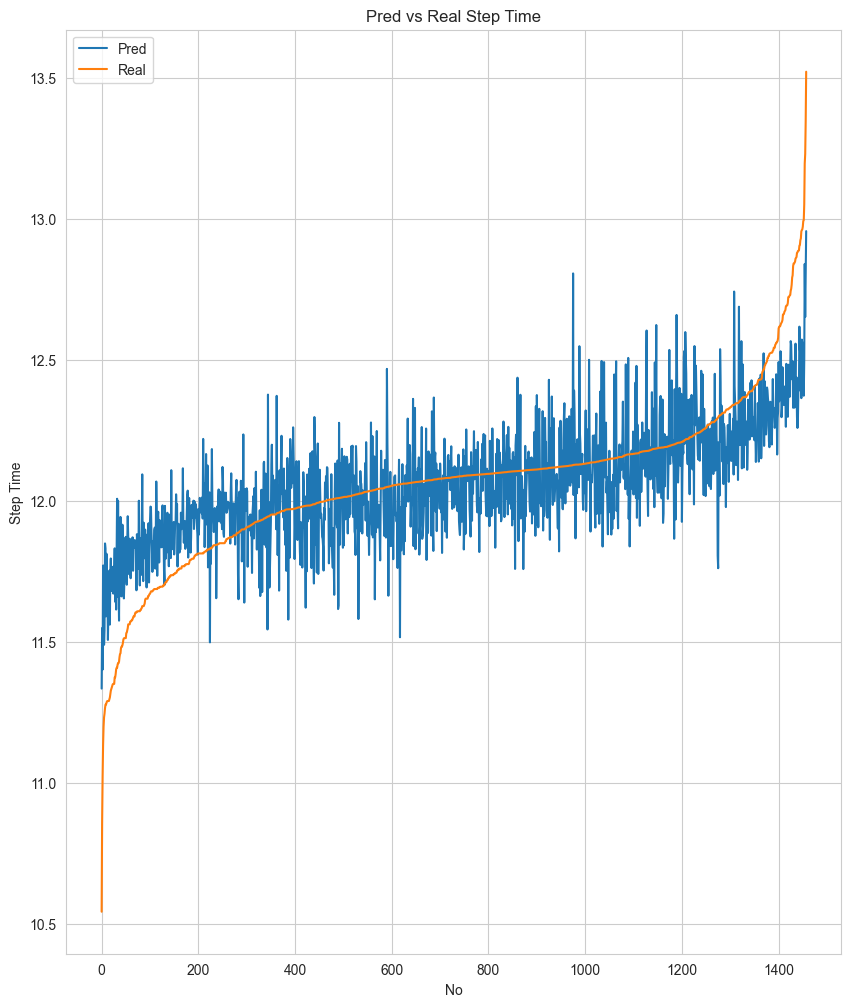

In [46]:
linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(data_num_train.drop('SalePrice', axis=1), data_num_train['SalePrice'])

train_pred = linear_regressor.predict(data_num_train.drop('SalePrice', axis=1))
rme_train = mean_squared_error(data_num_train['SalePrice'], train_pred)
print(rme_train)

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

0.047085313498880815


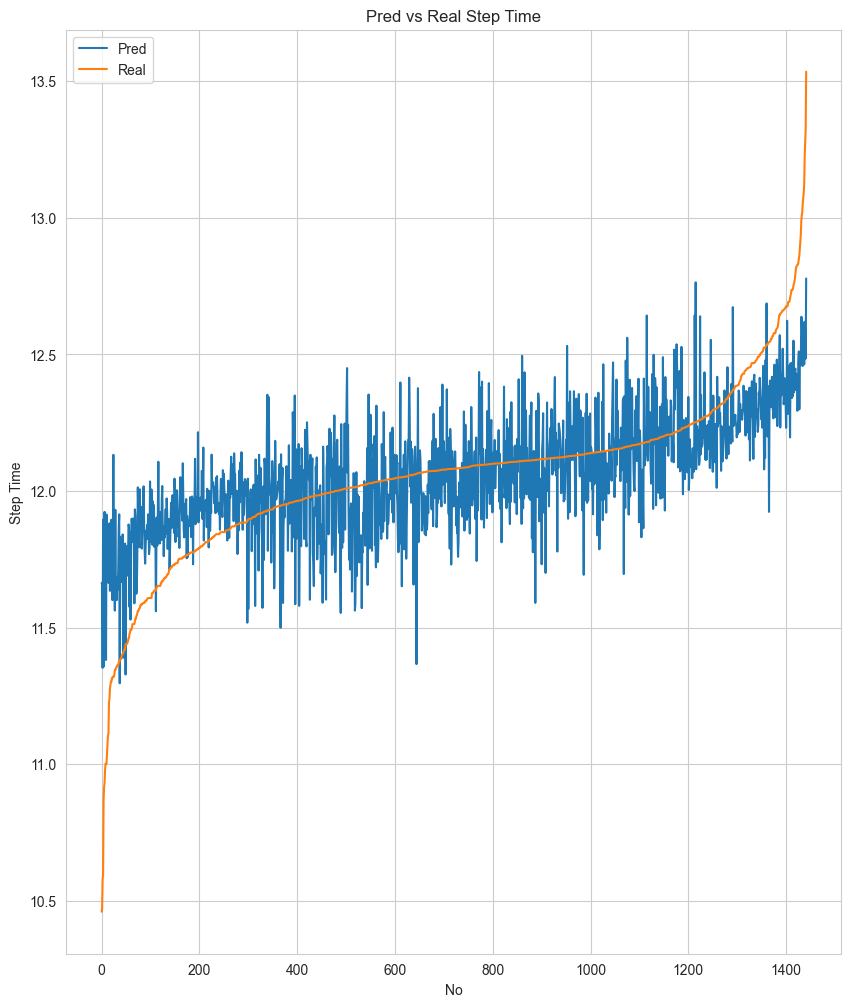

In [48]:
test_pred = linear_regressor.predict(data_num_test.drop('SalePrice', axis=1))
rme_test = mean_squared_error(data_num_test['SalePrice'], test_pred)
print(rme_test)

draw_pred_lines(test_pred, data_num_test['SalePrice'].to_list())

# 2. Decision Tree model

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

MSE=0.004652501891136028, R2_score=0.9997167396146275


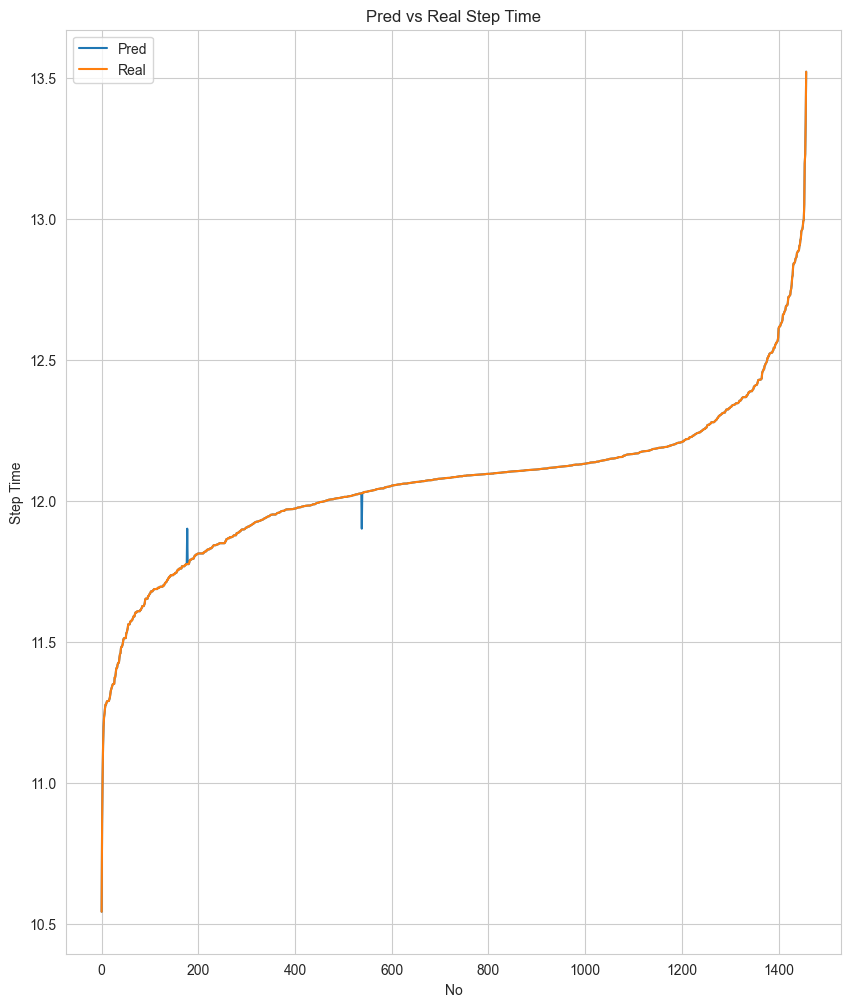

In [53]:
dt_model = DecisionTreeRegressor()
dt_model.fit(data_num_train.drop('SalePrice', axis=1), data_num_train['SalePrice'])

train_pred = dt_model.predict(data_num_train.drop('SalePrice', axis=1))
mse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, squared=False)
r2_score_train = r2_score(data_num_train['SalePrice'], train_pred)
print(f"MSE={mse_train}, R2_score={r2_score_train}")

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

On test data:
MSE=0.0828814163083825, R2_score=0.0935282161421116


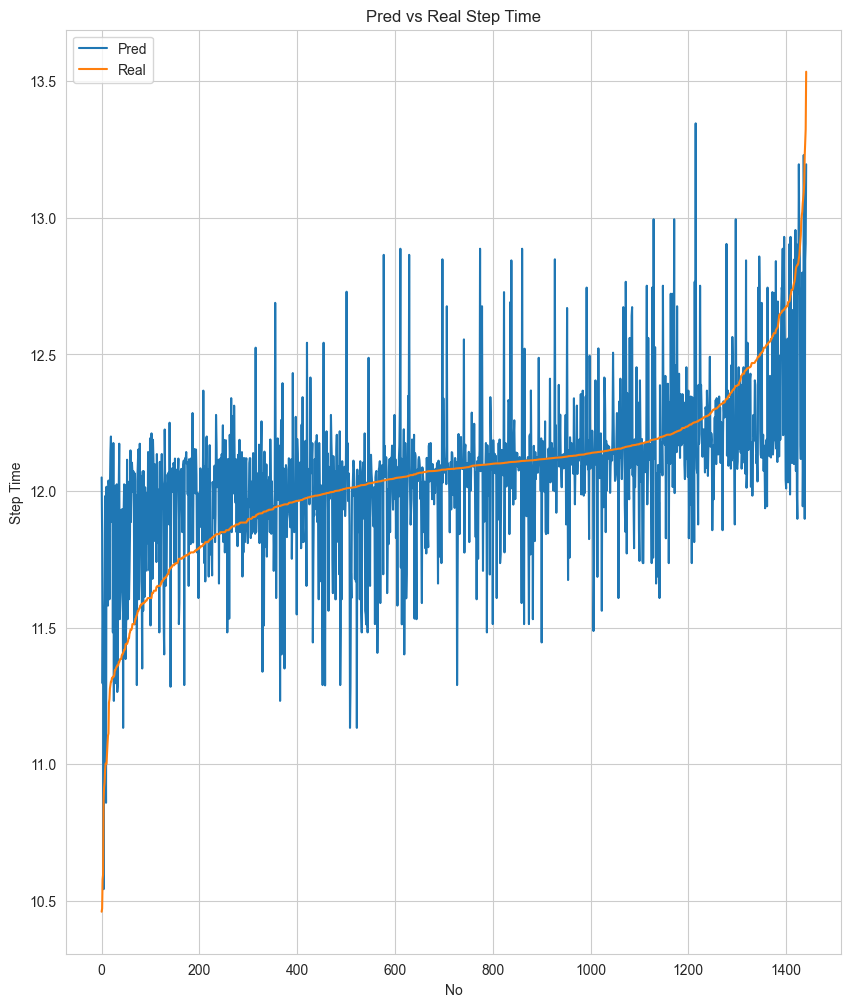

In [55]:
test_pred = dt_model.predict(data_num_test.drop('SalePrice', axis=1))
mse_test = mean_squared_error(data_num_test['SalePrice'], test_pred)
r2_score_test = r2_score(data_num_test['SalePrice'], test_pred)
print("On test data:")
print(f"MSE={mse_test}, R2_score={r2_score_test}")

draw_pred_lines(test_pred, data_num_test['SalePrice'].to_list())

# 3. Random Forest model

In [56]:
from sklearn.ensemble import RandomForestRegressor

MSE=0.07739813586043598, R2_score=0.9216076422520176


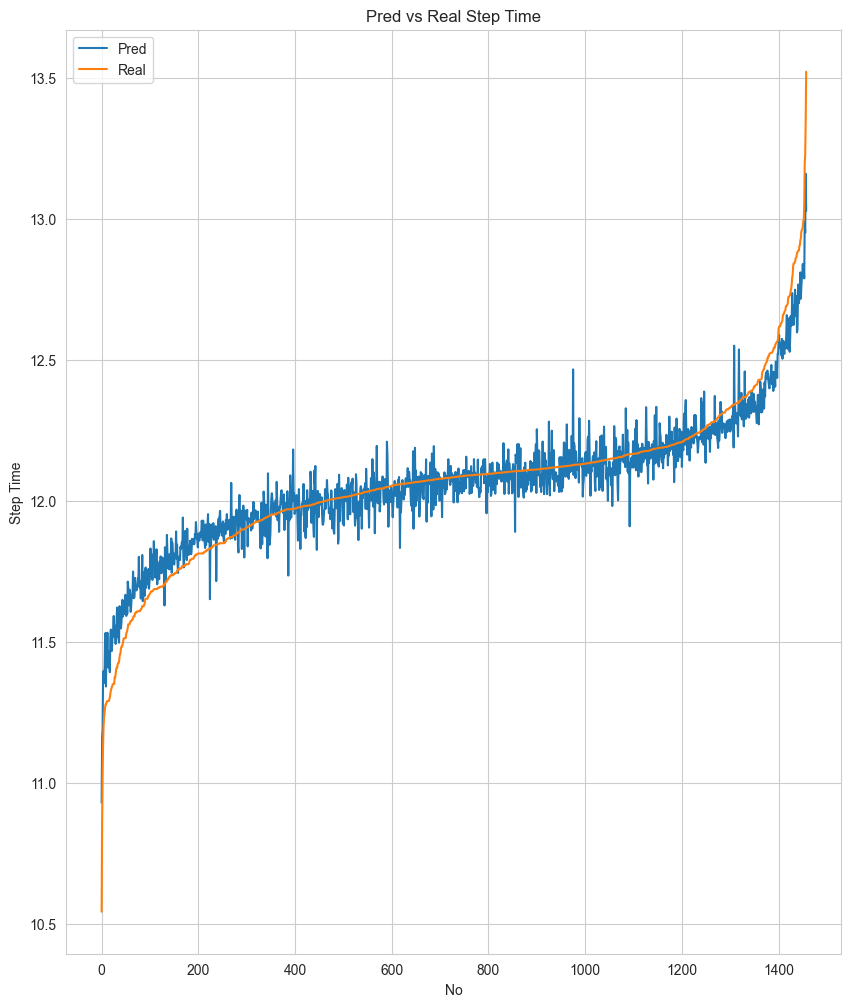

In [57]:
rf_model = RandomForestRegressor()
rf_model.fit(data_num_train.drop('SalePrice', axis=1), data_num_train['SalePrice'])

train_pred = rf_model.predict(data_num_train.drop('SalePrice', axis=1))
mse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, squared=False)
r2_score_train = r2_score(data_num_train['SalePrice'], train_pred)
print(f"MSE={mse_train}, R2_score={r2_score_train}")

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

On test data:
MSE=0.04769282124249885, R2_score=0.47838491818182305


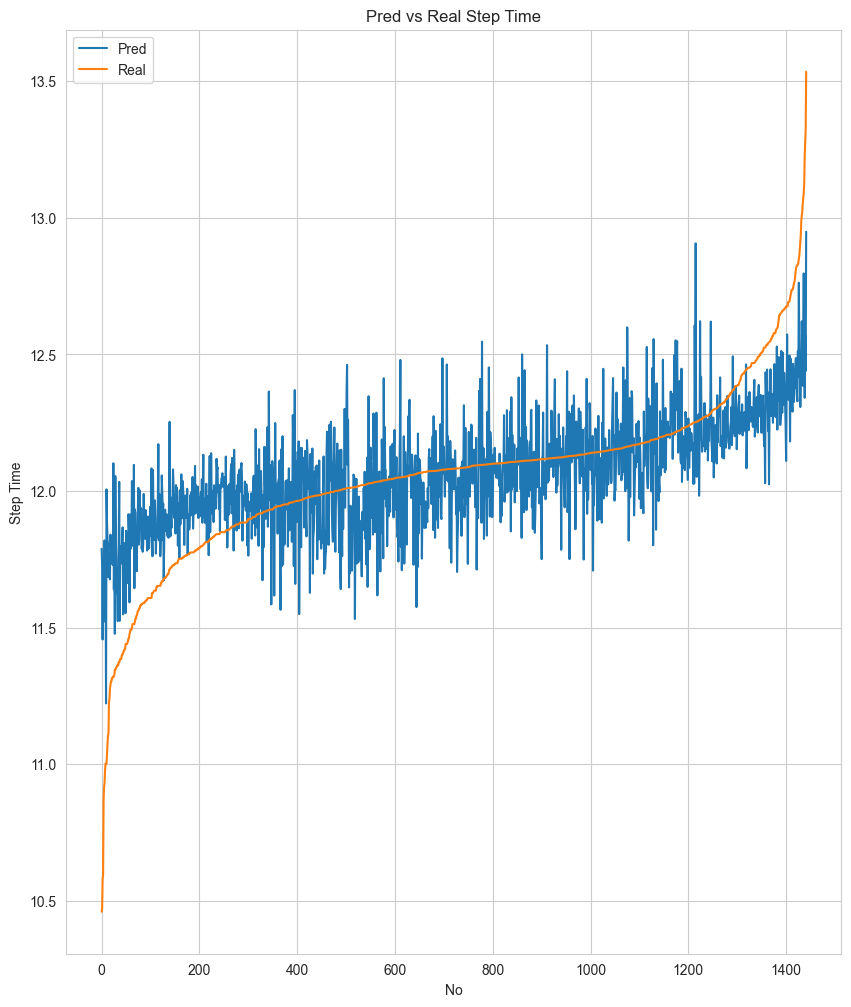

In [59]:
test_pred = rf_model.predict(data_num_test.drop('SalePrice', axis=1))
mse_test = mean_squared_error(data_num_test['SalePrice'], test_pred)
r2_score_test = r2_score(data_num_test['SalePrice'], test_pred)
print("On test data:")
print(f"MSE={mse_test}, R2_score={r2_score_test}")

draw_pred_lines(test_pred, data_num_test['SalePrice'].to_list())

# 4. Gradient Boosting Regression

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

MSE=0.025591884679872487, R2_score=0.6651001175535995


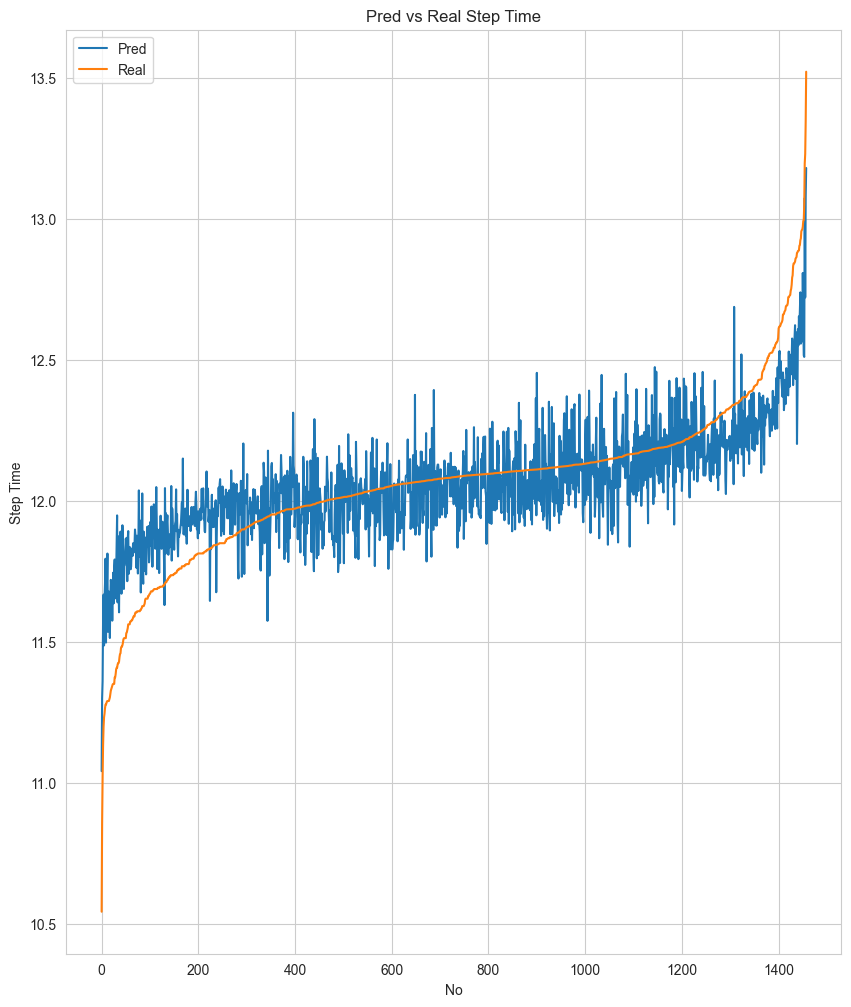

In [61]:
gbr_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=0)

gbr_model.fit(data_num_train.drop('SalePrice', axis=1), data_num_train['SalePrice'])

train_pred = gbr_model.predict(data_num_train.drop('SalePrice', axis=1))
mse_train = mean_squared_error(data_num_train['SalePrice'], train_pred)
r2_score_train = r2_score(data_num_train['SalePrice'], train_pred)
print(f"MSE={mse_train}, R2_score={r2_score_train}")

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

On test data:
MSE=0.048073498767551154, R2_score=0.47422145849956054


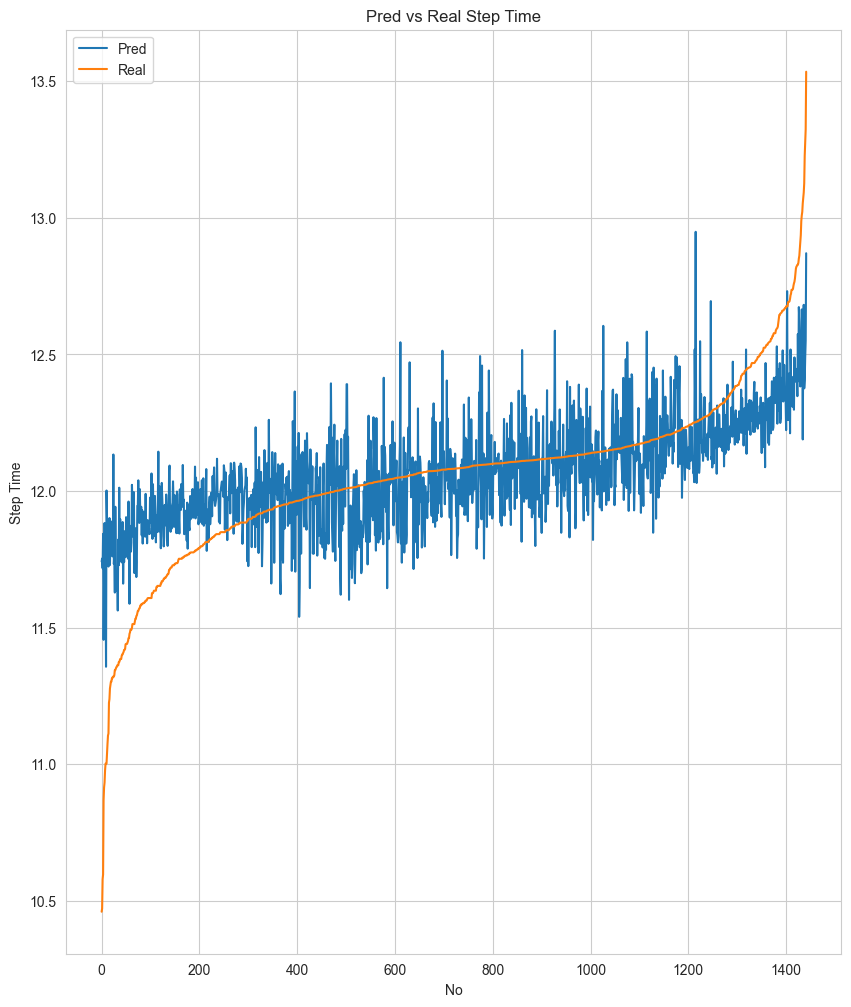

In [62]:
test_pred = gbr_model.predict(data_num_test.drop('SalePrice', axis=1))
mse_test = mean_squared_error(data_num_test['SalePrice'], test_pred)
r2_score_test = r2_score(data_num_test['SalePrice'], test_pred)
print("On test data:")
print(f"MSE={mse_test}, R2_score={r2_score_test}")

draw_pred_lines(test_pred, data_num_test['SalePrice'].to_list())

# ANN Regression

In [63]:
from keras import models
from keras import layers

In [64]:
model = models.Sequential()

model.add(layers.Dense(units=256, input_shape=(None, len(data_num_train.columns) - 1), activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 256)         20480     
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_2 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_3 (Dense)             (None, None, 1)           2

In [65]:
epochs = 1500
history = model.fit(x=data_num_train.drop("SalePrice", axis=1), y=data_num_train["SalePrice"], validation_data=(data_num_test.drop("SalePrice", axis=1), data_num_test["SalePrice"]), epochs=epochs, batch_size=128)

Epoch 1/1500
46/46 [==============================] - 1s 8ms/step - loss: 14.7279 - val_loss: 0.3929
Epoch 2/1500
46/46 [==============================] - 0s 4ms/step - loss: 2.3579 - val_loss: 0.5169
Epoch 3/1500
46/46 [==============================] - 0s 5ms/step - loss: 2.1577 - val_loss: 2.8866
Epoch 4/1500
46/46 [==============================] - 0s 4ms/step - loss: 1.8159 - val_loss: 1.4640
Epoch 5/1500
46/46 [==============================] - 0s 5ms/step - loss: 1.5856 - val_loss: 0.6913
Epoch 6/1500
46/46 [==============================] - 0s 4ms/step - loss: 1.5713 - val_loss: 4.1489
Epoch 7/1500
46/46 [==============================] - 0s 5ms/step - loss: 1.5836 - val_loss: 1.9139
Epoch 8/1500
46/46 [==============================] - 0s 5ms/step - loss: 1.4494 - val_loss: 1.4888
Epoch 9/1500
46/46 [==============================] - 0s 4ms/step - loss: 1.3465 - val_loss: 1.4334
Epoch 10/1500
46/46 [==============================] - 0s 4ms/step - loss: 1.3342 - val_loss: 2.865

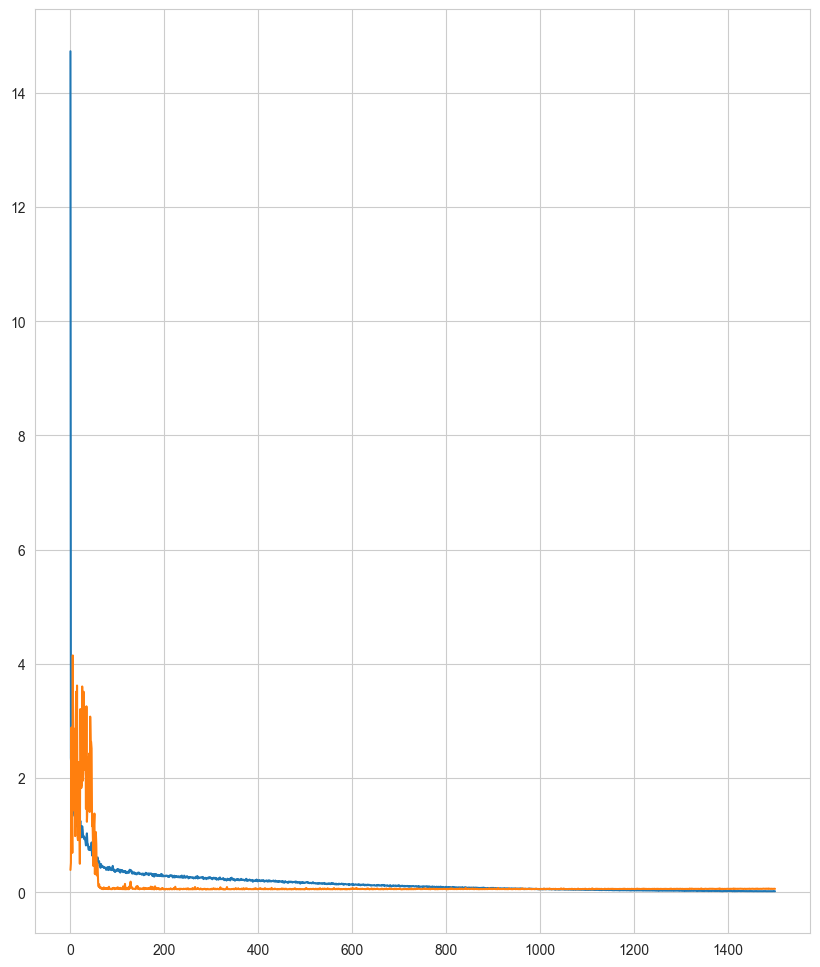

In [67]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.show()

0.012183395910200038


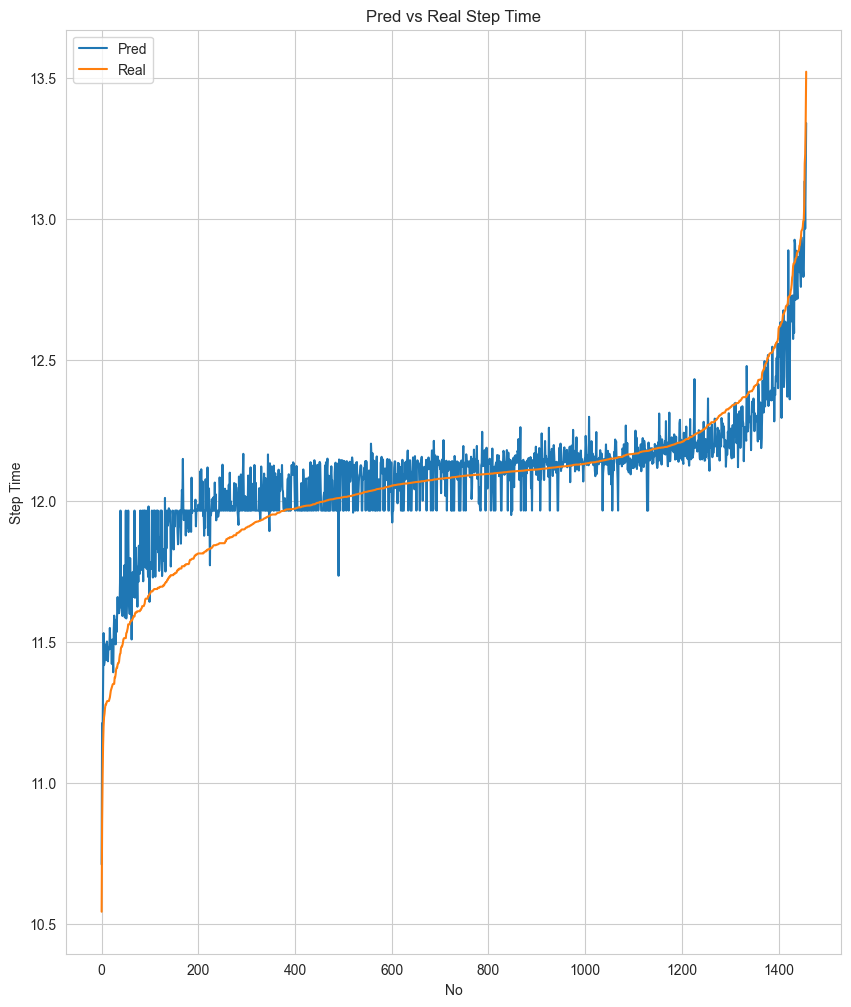

In [68]:
train_pred = model.predict(data_num_train.drop('SalePrice', axis=1), verbose=0)
rmse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, )
print(rmse_train)

draw_pred_lines(list(train_pred), data_num_train['SalePrice'].to_list())

0.06187906999803523


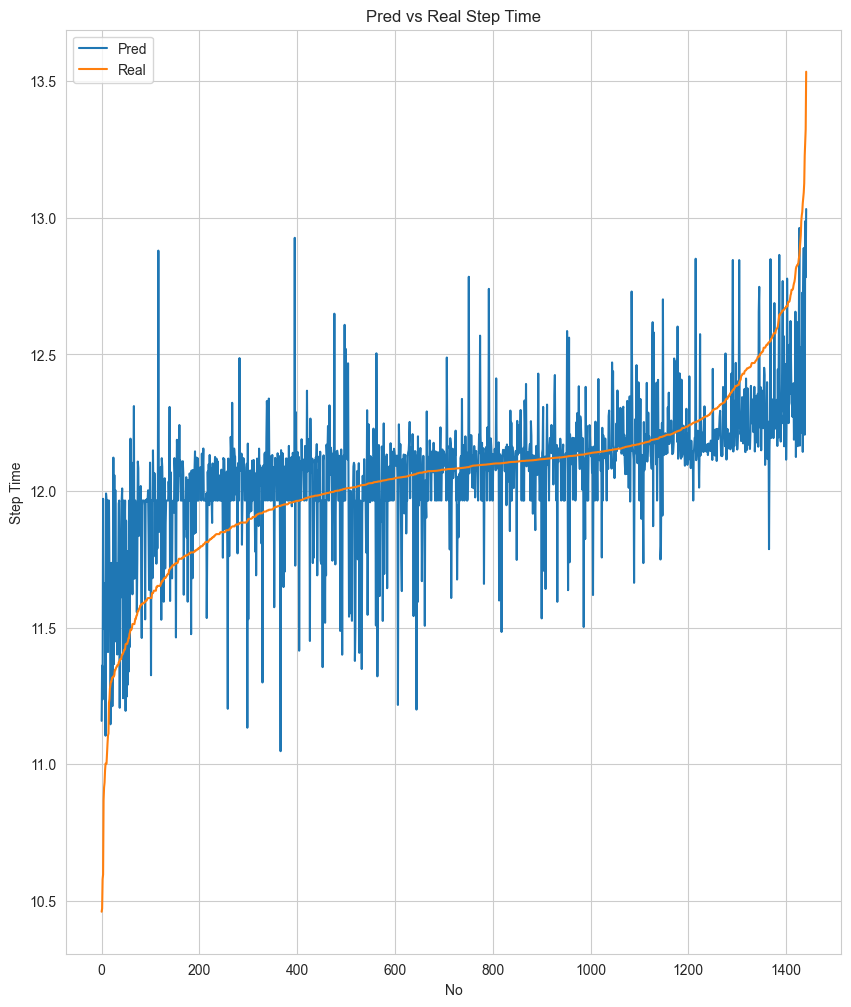

In [69]:
test_pred = model.predict(data_num_test.drop('SalePrice', axis=1), verbose=0)
rmse_test = mean_squared_error(data_num_test['SalePrice'], test_pred,)
print(rmse_test)

draw_pred_lines(list(test_pred), data_num_test['SalePrice'].to_list())

In [70]:
model = models.Sequential()

model.add(layers.Dense(units=256, input_shape=(None, len(data_num_train.columns) - 1), activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=1))

model.compile(optimizer="adam", loss="mean_absolute_error")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 256)         20480     
                                                                 
 dropout_3 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_5 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_6 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_7 (Dense)             (None, None, 1)          

In [71]:
epochs = 1500
history = model.fit(x=data_num_train.drop("SalePrice", axis=1), y=data_num_train["SalePrice"],
                    validation_data=(data_num_test.drop("SalePrice", axis=1), data_num_test["SalePrice"]),
                    epochs=epochs, batch_size=128)

Epoch 1/1500
12/12 [==============================] - 1s 17ms/step - loss: 6.1787 - val_loss: 0.7789
Epoch 2/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.8475 - val_loss: 1.2928
Epoch 3/1500
12/12 [==============================] - 0s 8ms/step - loss: 1.5522 - val_loss: 0.5920
Epoch 4/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.3473 - val_loss: 0.8377
Epoch 5/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.1955 - val_loss: 0.8537
Epoch 6/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.1469 - val_loss: 0.8649
Epoch 7/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.1232 - val_loss: 0.5740
Epoch 8/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.0516 - val_loss: 0.8814
Epoch 9/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.0086 - val_loss: 0.7588
Epoch 10/1500
12/12 [==============================] - 0s 7ms/step - loss: 1.0107 - val_loss: 0.738

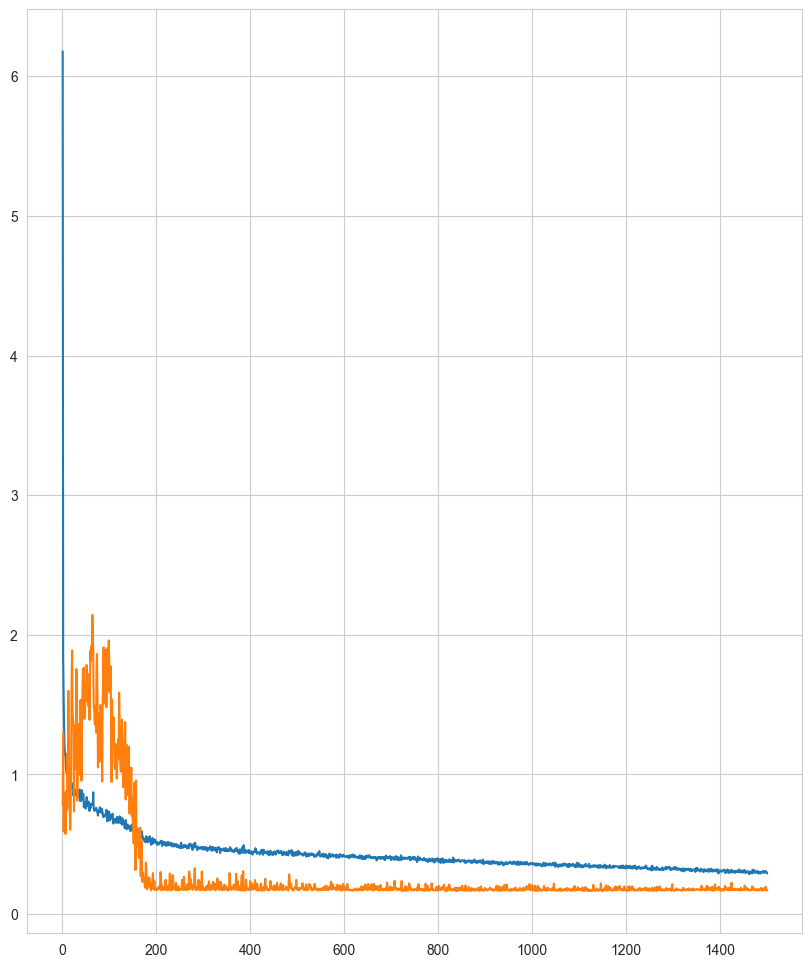

In [72]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.show()

0.013059245942275198


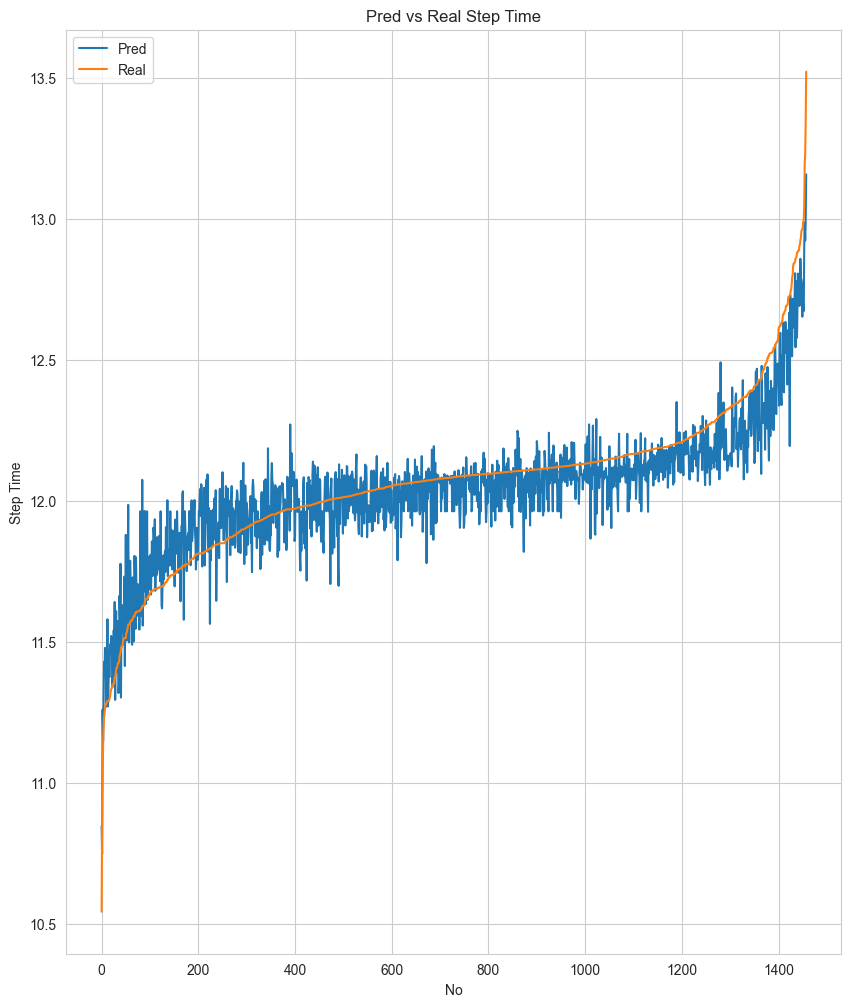

In [73]:
train_pred = model.predict(data_num_train.drop('SalePrice', axis=1), verbose=0)
rmse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, )
print(rmse_train)

draw_pred_lines(list(train_pred), data_num_train['SalePrice'].to_list())

0.05990014541251852


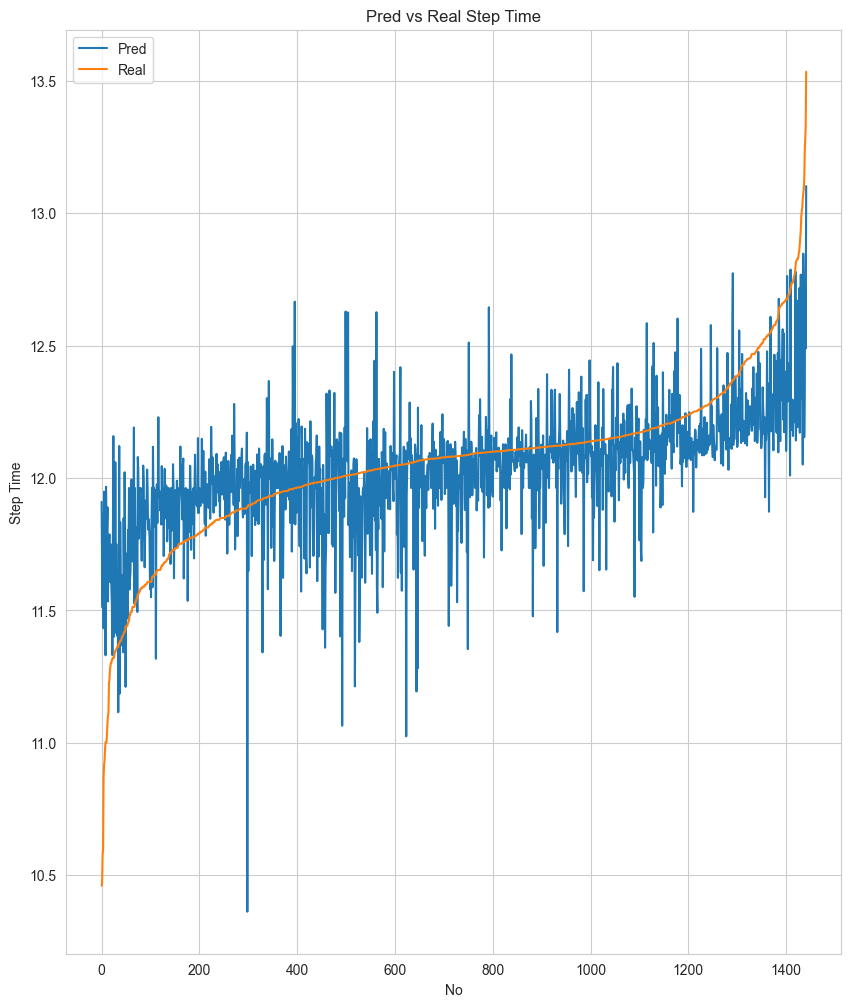

In [74]:
test_pred = model.predict(data_num_test.drop('SalePrice', axis=1), verbose=0)
rmse_test = mean_squared_error(data_num_test['SalePrice'], test_pred, )
print(rmse_test)

draw_pred_lines(list(test_pred), data_num_test['SalePrice'].to_list())

In [81]:
model = models.Sequential()

model.add(layers.Dense(units=512, input_shape=(None, len(data_num_train.columns) - 1), activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=1))

model.compile(optimizer="adam", loss="mean_absolute_error")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, None, 512)         40960     
                                                                 
 dropout_12 (Dropout)        (None, None, 512)         0         
                                                                 
 dense_17 (Dense)            (None, None, 512)         262656    
                                                                 
 dropout_13 (Dropout)        (None, None, 512)         0         
                                                                 
 dense_18 (Dense)            (None, None, 512)         262656    
                                                                 
 dropout_14 (Dropout)        (None, None, 512)         0         
                                                                 
 dense_19 (Dense)            (None, None, 1)          

Epoch 1/1500
6/6 [==============================] - 0s 34ms/step - loss: 0.3052 - val_loss: 0.1804
Epoch 2/1500
6/6 [==============================] - 0s 23ms/step - loss: 0.3036 - val_loss: 0.1744
Epoch 3/1500
6/6 [==============================] - 0s 25ms/step - loss: 0.3107 - val_loss: 0.1963
Epoch 4/1500
6/6 [==============================] - 0s 23ms/step - loss: 0.3174 - val_loss: 0.1642
Epoch 5/1500
6/6 [==============================] - 0s 26ms/step - loss: 0.3058 - val_loss: 0.1641
Epoch 6/1500
6/6 [==============================] - 0s 24ms/step - loss: 0.3153 - val_loss: 0.1709
Epoch 7/1500
6/6 [==============================] - 0s 26ms/step - loss: 0.3107 - val_loss: 0.1843
Epoch 8/1500
6/6 [==============================] - 0s 25ms/step - loss: 0.3074 - val_loss: 0.1674
Epoch 9/1500
6/6 [==============================] - 0s 29ms/step - loss: 0.3056 - val_loss: 0.1753
Epoch 10/1500
6/6 [==============================] - 0s 22ms/step - loss: 0.3019 - val_loss: 0.1684
Epoch 11/

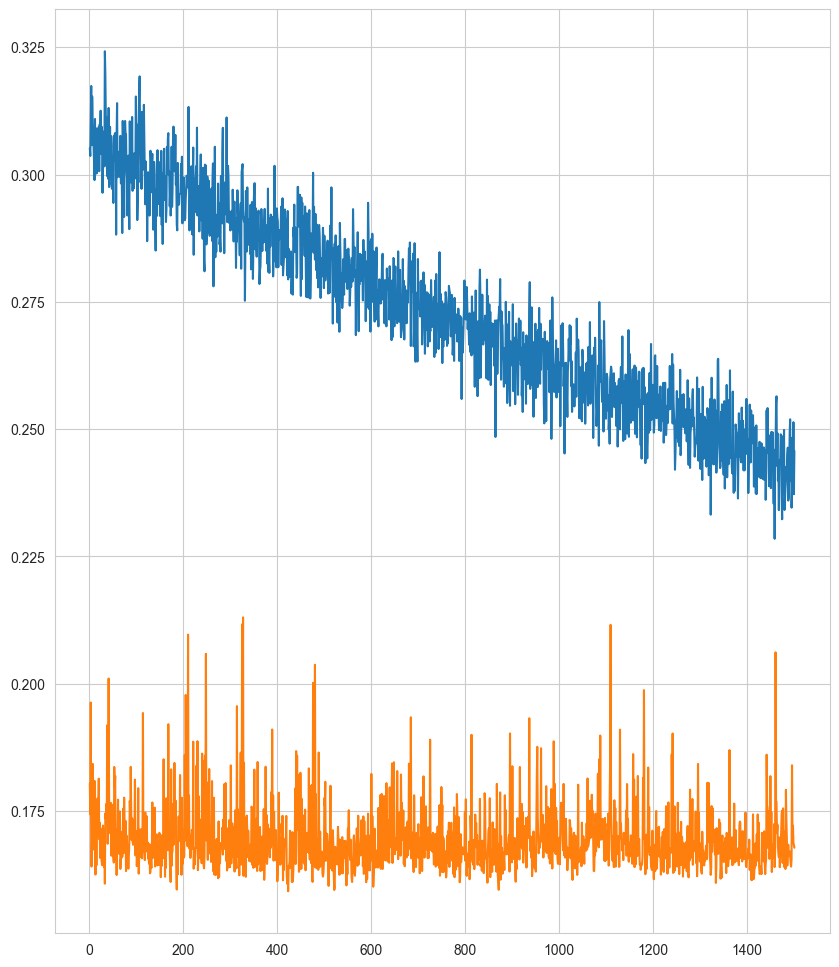

In [85]:
epochs = 1500
history = model.fit(x=data_num_train.drop("SalePrice", axis=1), y=data_num_train["SalePrice"],
                    validation_data=(data_num_test.drop("SalePrice", axis=1), data_num_test["SalePrice"]),
                    epochs=epochs, batch_size=256)
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.show()

0.007887154769180331


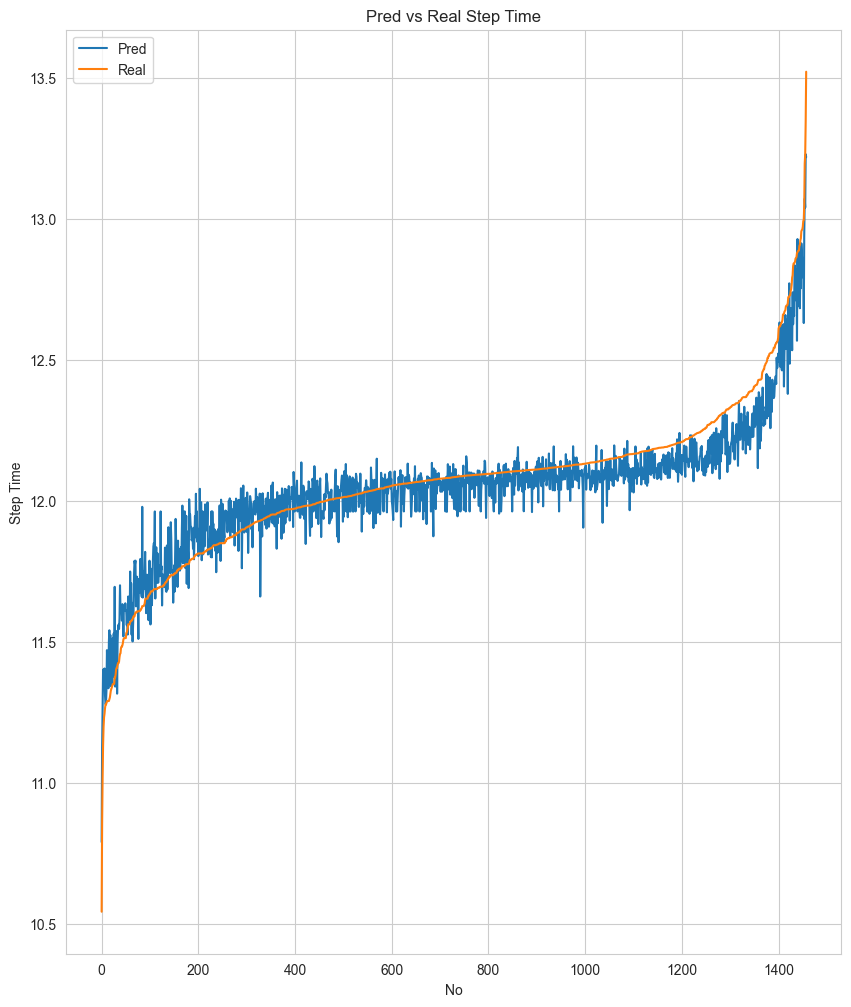

0.05995751821684299


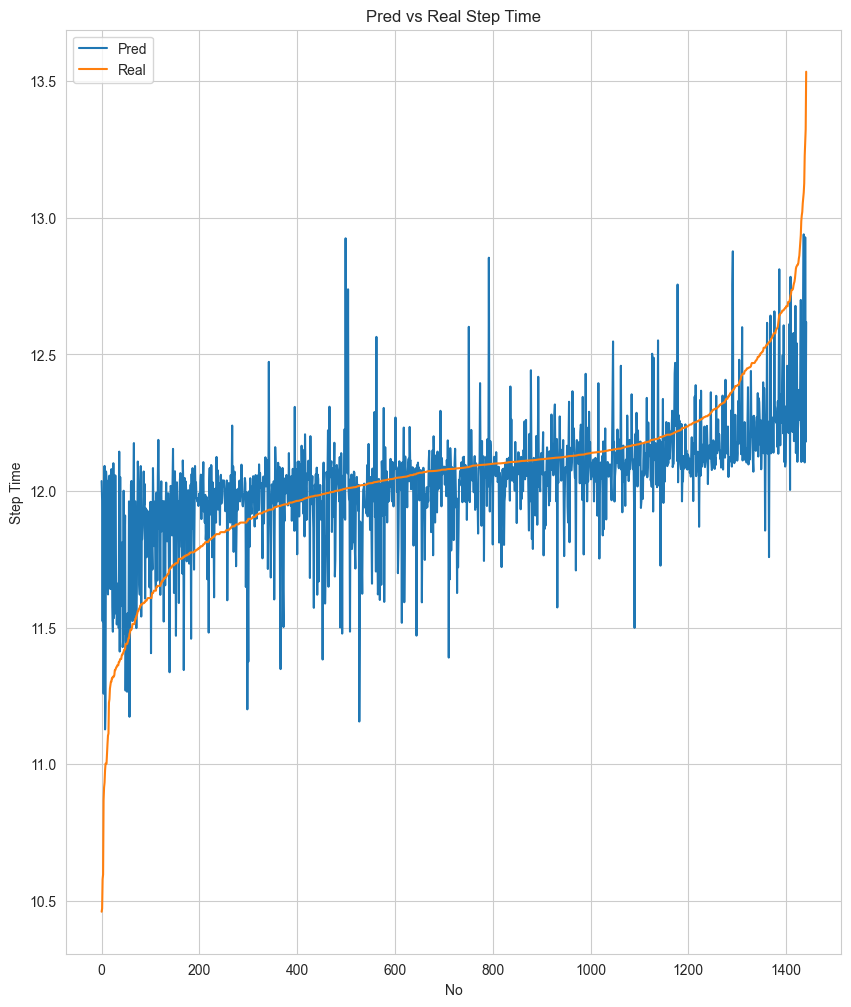

In [86]:
train_pred = model.predict(data_num_train.drop('SalePrice', axis=1), verbose=0)
rmse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, )
print(rmse_train)

draw_pred_lines(list(train_pred), data_num_train['SalePrice'].to_list())



test_pred = model.predict(data_num_test.drop('SalePrice', axis=1), verbose=0)
rmse_test = mean_squared_error(data_num_test['SalePrice'], test_pred, )
print(rmse_test)

draw_pred_lines(list(test_pred), data_num_test['SalePrice'].to_list())